In [1]:
import os
from pathlib import Path

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
os.environ["JAX_DEBUG_NANS"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import matplotlib.pyplot as plt
import h5py
import jax
import jax.numpy as jnp
import flv_utils as flv

from flv_utils import (
    by_class,
    by_multiclass,
    print_dict_structure,
    h5_to_dict,
    dict_to_h5,
    fig4_neuron_classes
)

import cepnem_jax as cj

Sourcing files from flv-c servers


INFO:2025-08-20 12:23:25,420:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-20 12:23:25,421:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
/storage/fs/store1/candy/candy_cepnem/private_cepnem_jax/.venv/lib/python3.12/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:677: DeprecationWarning: jax.interpreters.xla.pytype_aval_mappings is deprecated.
  jax.interpreters.xla.pytype_aval_mappings[onp.ndarray])
/storage/fs/store1/candy/candy_cepnem/private_cepnem_jax/.ve

In [2]:
def variance_explained(A: np.ndarray, B: np.ndarray) -> float:
    """Proportion of variance in B explained by A using simple linear regression."""
    A = A.ravel()
    B = B.ravel()

    # Fit linear regression: B = alpha + beta * A
    A_mean = np.mean(A)
    B_mean = np.mean(B)

    beta = np.sum((A - A_mean) * (B - B_mean)) / np.sum((A - A_mean) ** 2)
    alpha = B_mean - beta * A_mean

    B_pred = alpha + beta * A

    # R^2 = 1 - var(residuals) / var(B)
    ss_total = np.var(B, ddof=0)
    ss_resid = np.var(B - B_pred, ddof=0)

    return 1 - ss_resid / ss_total


def _combine(pair1, pair2):
    r1, a1 = pair1
    r2, a2 = pair2
    return (r1 * r2, a2 + r2 * a1)
    

def noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh):
    """Returns the noiseless neuron activation prediction for the CePNEM model"""
    # Compute the rectification and the activation
    E = s / (s + 1)  # EMA decay factor
    R = (c_vT + 1) / jnp.sqrt(c_vT**2 + 1)  # Rectification factor
    M = -2 * c_vT / jnp.sqrt(c_vT**2 + 1)  # Modulation factor

    # Compute the activation
    std_v, std_th, std_P = std_beh.T
    a_t = (R + M * (std_v < 0)) * (c_v * std_v + c_θh * std_th + c_P * std_P) / (s + 1)

    A = a_t + b * (1.0 - E)

    # Prepare the pairs for the associative scan
    pairs = (jnp.full_like(A, E), A)
    r_pref, a_pref = jax.lax.associative_scan(_combine, pairs, axis=0)

    # Compute the final activation
    return y0 * r_pref + a_pref


def noiseless_one_animal(params, behs, animal_idx=0):
    """Return (S, T): predictions for one animal across S samples."""
    beh_single = jnp.asarray(behs[animal_idx])            # (T, 3)

    # Per-sample parameter vectors (S,)
    c_vT = jnp.asarray(params['c_vT']).reshape(-1)
    c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
    c_th = jnp.asarray(params['c_θh']).reshape(-1)
    c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
    svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

    # Baseline for this animal across samples -> (S,)
    b_all = jnp.asarray(params['local']['b'])             # (S, N) or (S, 1, N)
    bvec  = jnp.squeeze(jnp.take(b_all, animal_idx, axis=-1)).reshape(-1)

    f = jax.vmap(
        lambda c_vT_i, c_v_i, c_th_i, c_P_i, s_i, b_i:
            noiseless_model(c_vT_i, c_v_i, c_th_i, c_P_i, 0., s_i, b_i, beh_single),
        in_axes=(0, 0, 0, 0, 0, 0)
    )
    return jax.jit(f)(c_vT, c_v, c_th, c_P, svec, bvec)   # (S, T)


def noiseless_all_animals(params, behs):
    """Return (N, S, T): predictions for all animals."""
    # Stack behaviors so we can vmap over animals without list indexing
    beh_stack = jnp.stack([jnp.asarray(b) for b in behs], axis=0)  # (N, T, 3)
    N = beh_stack.shape[0]
    animal_idx = jnp.arange(N)                                     # traced indices OK now

    def per_animal(beh_single, ai):
        # Same logic as noiseless_one_animal but avoid list indexing
        c_vT = jnp.asarray(params['c_vT']).reshape(-1)
        c_v  = jnp.asarray(params['c_v' ]).reshape(-1)
        c_th = jnp.asarray(params['c_θh']).reshape(-1)
        c_P  = jnp.asarray(params['c_P' ]).reshape(-1)
        svec = jnp.asarray(cj.compute_s(params['s0'])).reshape(-1).astype(float)

        b_all = jnp.asarray(params['local']['b'])                  # (S, N) or (S, 1, N)
        bvec  = jnp.squeeze(jnp.take(b_all, ai, axis=-1)).reshape(-1)

        f = jax.vmap(
            lambda c_vT_i, c_v_i, c_th_i, c_P_i, s_i, b_i:
                noiseless_model(c_vT_i, c_v_i, c_th_i, c_P_i, 0., s_i, b_i, beh_single),
            in_axes=(0, 0, 0, 0, 0, 0)
        )
        return f(c_vT, c_v, c_th, c_P, svec, bvec)                 # (S, T)

    vm = jax.vmap(per_animal, in_axes=(0, 0))
    return jax.jit(vm)(beh_stack, animal_idx)                      # (N, S, T)


def generate_traces(posterior, beh, animal_idx):  # per animal
    generated = noiseless_one_animal(posterior, beh, animal_idx=animal_idx)
    median_traces = jnp.median(generated, axis=0)  # take median across traces generated from many samples
    std_traces = jnp.std(generated, axis=0)
    return median_traces, std_traces

# def noiseless_model_ablated(c_vT, c_θh, c_P, y0, s, b, std_beh):
#     """Returns the noiseless neuron activation prediction for the CePNEM model"""
#     # Compute the rectification and the activation
#     E = s / (s + 1)  # EMA decay factor
#     R = (c_vT + 1) / jnp.sqrt(c_vT**2 + 1)  # Rectification factor
#     M = -2 * c_vT / jnp.sqrt(c_vT**2 + 1)  # Modulation factor

#     # Compute the activation
#     std_v, std_th, std_P = std_beh.T
#     # a_t = (R + M * (std_v < 0)) * (c_v * std_v + c_θh * std_th + c_P * std_P) / (s + 1)
#     a_t = (R + M * (std_v < 0)) * (c_θh * std_th + c_P * std_P) / (s + 1)

#     A = a_t + b * (1.0 - E)

#     # Prepare the pairs for the associative scan
#     pairs = (jnp.full_like(A, E), A)
#     r_pref, a_pref = jax.lax.associative_scan(_combine, pairs, axis=0)

#     # Compute the final activation
#     return y0 * r_pref + a_pref

## Degradation test on a particular neuron class

In [3]:
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250731'
# ablated_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250804_ablate_cv'
# ablated_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250805_zeroBeh'

nc = 'M3'
group = 'just_fed'
# group = 'gfp'

path_output_full = f'{full_model_dir}/{nc}/{group}.h5'
# path_output_ablated = f'{ablated_model_dir}/{nc}/{group}_zero_beh.h5'

result_full = flv.h5_to_dict(path_output_full)
output_full = result_full['CePNEMOutput']

# result_ablated = flv.h5_to_dict(path_output_ablated)
# output_ablated = result_ablated['CePNEMOutput']

In [4]:
animal_idx = 3

std_beh = result_full['beh']
std_beh_zero_beh = jnp.zeros_like(std_beh)

std_beh_zero_vel = std_beh.copy()
std_beh_zero_vel[:,:,0] = 0

std_beh_zero_th = std_beh.copy()
std_beh_zero_th[:,:,1] = 0

std_beh_zero_pump = std_beh.copy()
std_beh_zero_pump[:,:,2] = 0

ys = result_full['ys']
posterior_full = output_full['posterior_samples']
    
median_full, std_full           = generate_traces(posterior_full, std_beh, animal_idx)
median_zero_vel, std_zero_vel   = generate_traces(posterior_full, std_beh_zero_vel, animal_idx)
median_zero_th, std_zero_th     = generate_traces(posterior_full, std_beh_zero_th, animal_idx)
median_zero_pump, std_zero_pump = generate_traces(posterior_full, std_beh_zero_pump, animal_idx)
median_zero_beh, std_zero_beh   = generate_traces(posterior_full, std_beh_zero_beh, animal_idx)

# # Train an ablated model
# posterior_ablated = output_ablated['posterior_samples']
# noiseless_fn = noiseless_beh(std_beh, animal_idx=animal_idx)
# generated_ablated = noiseless_fn(posterior_ablated, std_beh)
# median_ablated = jnp.median(generated_ablated, axis=0)
# std_ablated = jnp.std(generated_ablated, axis=0)

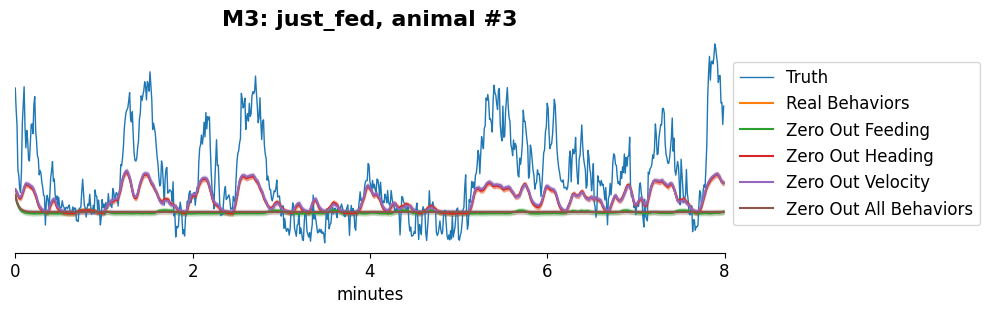

In [5]:
# Visualize generated traces
plt.figure(figsize=(10,3))

# Plot truth (no shading needed)
plt.plot(ys[animal_idx], label='Truth', color='C0', linewidth=1)

# Plot model with all 3 behaviors + shaded region
line1 = plt.plot(median_full, label='Real Behaviors', color='C1')
color1 = line1[0].get_color()  # Get the color of the line
plt.fill_between(range(len(median_full)), 
                 median_full - std_full, 
                 median_full + std_full, 
                 color=color1, alpha=0.2)

# Plot zeroed pump + shaded region
line2 = plt.plot(median_zero_pump, label='Zero Out Feeding', color='C2')
color2 = line2[0].get_color()
plt.fill_between(range(len(median_zero_pump)), 
                 median_zero_pump - std_zero_pump, 
                 median_zero_pump + std_zero_pump, 
                 color=color2, alpha=0.2)
# Plot zeroed theta + shaded region
line3 = plt.plot(median_zero_th, label='Zero Out Heading', color='C3')
color3 = line3[0].get_color()
plt.fill_between(range(len(median_zero_th)), 
                 median_zero_th - std_zero_th, 
                 median_zero_th + std_zero_th, 
                 color=color3, alpha=0.2)
# Plot zeroed velocity + shaded region
line4 = plt.plot(median_zero_vel, label='Zero Out Velocity', color='C4')
color4 = line4[0].get_color()
plt.fill_between(range(len(median_zero_vel)), 
                 median_zero_vel - std_zero_vel, 
                 median_zero_vel + std_zero_vel, 
                 color=color4, alpha=0.2)

# Plot zeroed behavior + shaded region
line5 = plt.plot(median_zero_beh, label='Zero Out All Behaviors', color='C5')
color5 = line5[0].get_color()
plt.fill_between(range(len(median_zero_beh)), 
                 median_zero_beh - std_zero_beh, 
                 median_zero_beh + std_zero_beh, 
                 color=color5, alpha=0.2)

plt.xlim(0,800)
plt.xticks([0,200,400,600,800], [0,2,4,6,8], fontsize=12)
plt.xlabel('minutes', fontsize=12)

# Remove y-axis and spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_yticks([])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout()
plt.title(f'{nc}: {group}, animal #{animal_idx}', fontweight='bold', fontsize=16)
plt.show()

In [94]:
# std_beh = result_full['beh']  #(n_t, 3), depends on the animal
# ys = result_full['ys']

# # Load full model, then set one coefficient to zero
# posterior_full = output_full['posterior_samples']
# c_vT = jnp.median(posterior_full['c_vT'])
# c_v  = jnp.median(posterior_full['c_v'])
# c_θh = jnp.median(posterior_full['c_θh'])
# c_P  = jnp.median(posterior_full['c_P'])
# y0   = 0
# s    = jnp.median(cj.compute_s(posterior_full['s0']))
# b    = jnp.median(posterior_full['local']['b'][:,:,animal_idx])
# generated_full = noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh[animal_idx])
# generated_zeroed = noiseless_model(c_vT, 0, c_θh, c_P, y0, s, b, std_beh[animal_idx])


# # Train an ablated model
# posterior_ablated = output_ablated['posterior_samples']
# c_vT = jnp.median(posterior_ablated['c_vT'])
# c_θh = jnp.median(posterior_ablated['c_θh'])
# c_P  = jnp.median(posterior_ablated['c_P'])
# y0   = 0
# s    = jnp.median(cj.compute_s(posterior_ablated['s0']))
# b    = jnp.median(posterior_ablated['local']['b'][:,:,animal_idx])
# generated_ablated = noiseless_model_ablated(c_vT, c_θh, c_P, y0, s, b, std_beh[animal_idx])


# # Visualize generated traces
# plt.figure(figsize=(12,3))
# plt.plot(ys[animal_idx], label='Truth')
# plt.plot(generated_full, label='Model with All 3 Behaviors')
# plt.plot(generated_zeroed, label='Model with All 3 Behaviors, then set c_v = 0')
# plt.plot(generated_ablated, label='Model without c_v term')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# plt.tight_layout()  # Optional: to prevent clipping
# plt.title(f'{nc}: {group}', fontweight='bold', fontsize=16)

In [98]:
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250731'

nc = 'M3'
group = 'just_fed'
# group = 'gfp'

path_output_full = f'{full_model_dir}/{nc}/{group}.h5'

result_full = flv.h5_to_dict(path_output_full)
output_full = result_full['CePNEMOutput']

In [99]:
n_animals = result_full['beh'].shape[0]
std_beh = result_full['beh'] 
std_beh_zero_beh = jnp.zeros_like(std_beh)

std_beh_zero_vel = std_beh.copy()
std_beh_zero_vel[:,:,0] = 0

std_beh_zero_th = std_beh.copy()
std_beh_zero_th[:,:,1] = 0

std_beh_zero_pump = std_beh.copy()
std_beh_zero_pump[:,:,2] = 0

ys = result_full['ys']
posterior_full = output_full['posterior_samples']

# Initialize arrays to store variance explained for each animal
ve_self_all = []
ve_full_all = []
ve_zeroed_beh_all = []
ve_zeroed_vel_all = []
ve_zeroed_th_all  = []
ve_zeroed_pump_all= []

for animal_idx in range(n_animals):
    # Load full model, then set one coefficient to zero
    c_vT = jnp.median(posterior_full['c_vT'])
    c_v  = jnp.median(posterior_full['c_v'])
    c_θh = jnp.median(posterior_full['c_θh'])
    c_P  = jnp.median(posterior_full['c_P'])
    y0   = 0
    s    = jnp.median(cj.compute_s(posterior_full['s0']))
    b    = jnp.median(posterior_full['local']['b'][:,:,animal_idx])
    generated_full = noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh[animal_idx])
    generated_zeroed_beh = noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh_zero_beh[animal_idx])
    generated_zeroed_vel = noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh_zero_vel[animal_idx])
    generated_zeroed_th  = noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh_zero_th[animal_idx])
    generated_zeroed_pump= noiseless_model(c_vT, c_v, c_θh, c_P, y0, s, b, std_beh_zero_pump[animal_idx])
    
    # Compute variance explained for this animal
    ve_self = 1.0   # always 1
    ve_full = variance_explained(generated_full, ys[animal_idx])
    ve_zeroed_beh = variance_explained(generated_zeroed_beh, ys[animal_idx])
    ve_zeroed_vel = variance_explained(generated_zeroed_vel, ys[animal_idx])
    ve_zeroed_th  = variance_explained(generated_zeroed_th, ys[animal_idx])
    ve_zeroed_pump= variance_explained(generated_zeroed_pump, ys[animal_idx])
    
    # Store results
    ve_self_all.append(ve_self)
    ve_full_all.append(ve_full)
    ve_zeroed_beh_all.append(ve_zeroed_beh)
    ve_zeroed_vel_all.append(ve_zeroed_vel)
    ve_zeroed_th_all.append(ve_zeroed_th)
    ve_zeroed_pump_all.append(ve_zeroed_pump)

# Convert to numpy arrays for easier computation
ve_self_all = np.array(ve_self_all)
ve_full_all = np.array(ve_full_all)
ve_zeroed_beh_all = np.array(ve_zeroed_beh_all)
ve_zeroed_vel_all = np.array(ve_zeroed_vel_all)
ve_zeroed_th_all  = np.array(ve_zeroed_th_all)
ve_zeroed_pump_all= np.array(ve_zeroed_pump_all)

# Compute means and standard deviations
mean_values = [np.mean(ve_self_all), np.mean(ve_full_all), np.mean(ve_zeroed_pump_all), np.mean(ve_zeroed_th_all), np.mean(ve_zeroed_vel_all), np.mean(ve_zeroed_beh_all)]
std_values  = [np.std(ve_self_all),  np.std(ve_full_all),  np.std(ve_zeroed_pump_all),  np.std(ve_zeroed_th_all),  np.std(ve_zeroed_vel_all),  np.std(ve_zeroed_beh_all)]

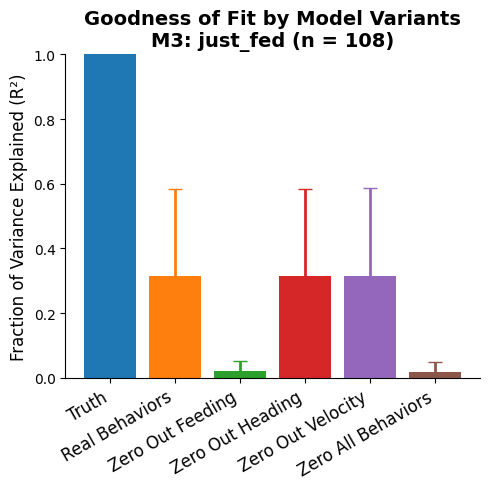

In [100]:
# Prepare data for bar plot
labels = ['Truth', 
          'Real Behaviors', 
          'Zero Out Feeding',
          'Zero Out Heading',
          'Zero Out Velocity', 
          'Zero All Behaviors',
         ]
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

# Plot
plt.figure(figsize=(5,5))

# Create bars and error bars separately to control colors
bars = plt.bar(labels, mean_values, color=colors)

# Add error bars with matching colors
for i, (bar, color) in enumerate(zip(bars, colors)):
    plt.errorbar(bar.get_x() + bar.get_width()/2, mean_values[i], 
                yerr=std_values[i], color=color, 
                capsize=5, linewidth=2, fmt='none')

plt.title(f'Goodness of Fit by Model Variants\n{nc}: {group} (n = {n_animals})', 
          fontsize=14, fontweight='bold')
plt.ylabel('Fraction of Variance Explained (R²)', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right', fontsize=12)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

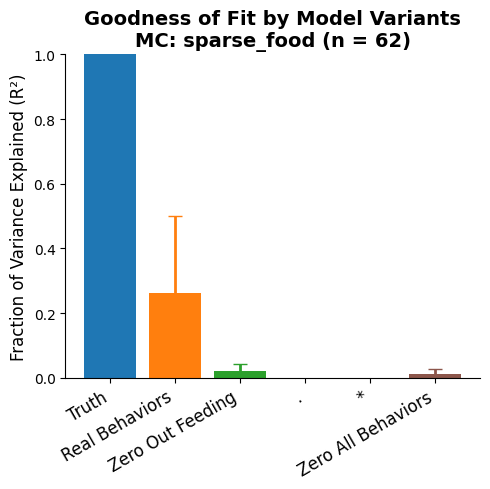

In [278]:
# Prepare data for bar plot
labels = ['Truth', 
          'Real Behaviors', 
          'Zero Out Feeding',
          '.',
          '*', 
          'Zero All Behaviors',
         ]
colors = ['C0', 'C1', 'C2', 'white', 'white', 'C5']  # White for empty bars

# Plot
plt.figure(figsize=(5,5))

# Create bars and error bars separately to control colors
bars = plt.bar(labels, mean_values, color=colors)

# Add error bars with matching colors
for i, (bar, color) in enumerate(zip(bars, colors)):
    plt.errorbar(bar.get_x() + bar.get_width()/2, mean_values[i], 
                yerr=std_values[i], color=color, 
                capsize=5, linewidth=2, fmt='none')

plt.title(f'Goodness of Fit by Model Variants\n{nc}: {group} (n = {n_animals})', 
          fontsize=14, fontweight='bold')
plt.ylabel('Fraction of Variance Explained (R²)', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right', fontsize=12)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Degrdation test on all neuron classes

In [5]:
import jax
import jax.numpy as jnp
from jax import vmap

def noiseless_model_batch_chunked(params, behs, chunk_size=1000):
    """Memory-efficient version that processes in chunks"""
    
    @jax.jit
    def process_chunk(params_chunk, behs):
        num_animals = len(behs)
        chunk_samples = params_chunk['c_vT'].size
        
        # Double vmap for the chunk
        def single_prediction(sample_idx, animal_idx):
            return noiseless_model(
                params_chunk['c_vT'].flatten()[sample_idx],
                params_chunk['c_v'].flatten()[sample_idx], 
                params_chunk['c_θh'].flatten()[sample_idx],
                params_chunk['c_P'].flatten()[sample_idx],
                0.,
                cj.compute_s(params_chunk['s0']).flatten().astype(float)[sample_idx],
                params_chunk['local']['b'].reshape(-1, params_chunk['local']['b'].shape[-1])[sample_idx, animal_idx],
                behs[animal_idx]
            )
        
        sample_indices = jnp.arange(chunk_samples)
        animal_indices = jnp.arange(num_animals)
        
        vectorized_fn = vmap(
            vmap(single_prediction, in_axes=(None, 0)),  # vmap over animals
            in_axes=(0, None)                            # vmap over samples
        )
        
        return vectorized_fn(sample_indices, animal_indices)
    
    # Get total samples and split into chunks
    total_samples = params['c_vT'].size
    num_chunks = (total_samples + chunk_size - 1) // chunk_size
    
    results = []
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, total_samples)
        
        # Create chunk of parameters
        chunk_params = {
            'c_vT': params['c_vT'].flatten()[start_idx:end_idx].reshape(-1, 1),
            'c_v': params['c_v'].flatten()[start_idx:end_idx].reshape(-1, 1),
            'c_θh': params['c_θh'].flatten()[start_idx:end_idx].reshape(-1, 1),
            'c_P': params['c_P'].flatten()[start_idx:end_idx].reshape(-1, 1),
            's0': params['s0'].flatten()[start_idx:end_idx].reshape(-1, 1),
            'local': {
                'b': params['local']['b'].reshape(-1, params['local']['b'].shape[-1])[start_idx:end_idx].reshape(-1, 1, params['local']['b'].shape[-1])
            }
        }
        
        chunk_result = process_chunk(chunk_params, behs)
        results.append(chunk_result)
    
    # Concatenate results along sample dimension
    return jnp.concatenate(results, axis=0)

# Alternative: Use median sampling instead of all samples
def noiseless_model_median_only(params, behs):
    """Much faster version using only median parameters"""
    
    @jax.jit
    def median_batch(params, behs):
        # Use median parameters only
        c_vT = jnp.median(params['c_vT'])
        c_v = jnp.median(params['c_v'])
        c_θh = jnp.median(params['c_θh'])
        c_P = jnp.median(params['c_P'])
        s = jnp.median(cj.compute_s(params['s0']))
        b_median = jnp.median(params['local']['b'], axis=(0,1))  # median across samples and chains
        
        num_animals = len(behs)
        animal_indices = jnp.arange(num_animals)
        
        def single_animal_prediction(animal_idx):
            return noiseless_model(c_vT, c_v, c_θh, c_P, 0., s, b_median[animal_idx], behs[animal_idx])
        
        return vmap(single_animal_prediction)(animal_indices)
    
    return median_batch(params, behs)

# Updated main loop with memory management
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/fits_truncated_20250731'
groups = ['copper', 'dense_food', 'sparse_food', 'just_fed', 'fasted', '1h_starved', 'gfp']
var_exp = dict()

for nc in fig4_neuron_classes:
    var_exp[nc] = dict()
    for group in groups:
        var_exp[nc][group] = dict()
        
        path_output_full = f'{full_model_dir}/{nc}/{group}.h5'
        if os.path.isfile(path_output_full):        
            result_full = flv.h5_to_dict(path_output_full)
            output_full = result_full['CePNEMOutput']
            n_animals = result_full['beh'].shape[0]
            
            # Convert to JAX arrays
            std_beh = jnp.array(result_full['beh'])
            ys = jnp.array(result_full['ys'])
            
            # Create behavior variants
            std_beh_zero_beh = jnp.zeros_like(std_beh)
            std_beh_zero_vel = std_beh.at[:,:,0].set(0)
            std_beh_zero_th = std_beh.at[:,:,1].set(0)  
            std_beh_zero_pump = std_beh.at[:,:,2].set(0)
            
            posterior_full = output_full['posterior_samples']
            
            print(f"Processing {nc} - {group} with {n_animals} animals...")
            
            # OPTION 1: Use median-only version (fastest, least memory)
            generated_full = noiseless_model_median_only(posterior_full, std_beh)
            generated_zeroed_beh = noiseless_model_median_only(posterior_full, std_beh_zero_beh)
            generated_zeroed_vel = noiseless_model_median_only(posterior_full, std_beh_zero_vel)
            generated_zeroed_th = noiseless_model_median_only(posterior_full, std_beh_zero_th)
            generated_zeroed_pump = noiseless_model_median_only(posterior_full, std_beh_zero_pump)
            
            # Compute variance explained (shape: (n_animals,))
            @jax.jit
            def variance_explained_vectorized(generated_batch, ys_batch):
                return vmap(variance_explained)(generated_batch, ys_batch)
            
            ve_full_all = variance_explained_vectorized(generated_full, ys)
            ve_zeroed_beh_all = variance_explained_vectorized(generated_zeroed_beh, ys)
            ve_zeroed_vel_all = variance_explained_vectorized(generated_zeroed_vel, ys)
            ve_zeroed_th_all = variance_explained_vectorized(generated_zeroed_th, ys)
            ve_zeroed_pump_all = variance_explained_vectorized(generated_zeroed_pump, ys)
            
            # Take median across animals
            var_exp[nc][group]['full'] = jnp.median(ve_full_all)
            var_exp[nc][group]['zero_beh'] = jnp.median(ve_zeroed_beh_all)
            var_exp[nc][group]['zero_vel'] = jnp.median(ve_zeroed_vel_all)
            var_exp[nc][group]['zero_th'] = jnp.median(ve_zeroed_th_all)
            var_exp[nc][group]['zero_pump'] = jnp.median(ve_zeroed_pump_all)
            
            # Clear GPU memory
            del generated_full, generated_zeroed_beh, generated_zeroed_vel, generated_zeroed_th, generated_zeroed_pump
            del ve_full_all, ve_zeroed_beh_all, ve_zeroed_vel_all, ve_zeroed_th_all, ve_zeroed_pump_all
            
        else:
            var_exp[nc][group]['full'] = jnp.nan
            var_exp[nc][group]['zero_beh'] = jnp.nan
            var_exp[nc][group]['zero_vel'] = jnp.nan
            var_exp[nc][group]['zero_th'] = jnp.nan
            var_exp[nc][group]['zero_pump'] = jnp.nan

Processing AVB - copper with 18 animals...
Processing AVB - sparse_food with 16 animals...
Processing AVB - just_fed with 80 animals...
Processing AVB - fasted with 64 animals...
Processing AVB - 1h_starved with 66 animals...
Processing AVB - gfp with 28 animals...
Processing RIB - copper with 42 animals...
Processing RIB - dense_food with 7 animals...
Processing RIB - sparse_food with 32 animals...
Processing RIB - just_fed with 92 animals...
Processing RIB - fasted with 88 animals...
Processing RIB - 1h_starved with 76 animals...
Processing RIB - gfp with 14 animals...
Processing RIC - copper with 74 animals...
Processing RIC - dense_food with 8 animals...
Processing RIC - sparse_food with 86 animals...
Processing RIC - just_fed with 99 animals...
Processing RIC - fasted with 76 animals...
Processing RIC - 1h_starved with 94 animals...
Processing RIC - gfp with 44 animals...
Processing RID - copper with 44 animals...
Processing RID - dense_food with 7 animals...
Processing RID - spar

In [6]:
# Save var_exp as a pickle file
import pickle
import os

pickle_path = os.path.join(full_model_dir, 'variance_explained_results.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(var_exp, f)

print(f"Results saved to: {pickle_path}")

Results saved to: /store1/candy/candy_cepnem/candy_testing/fits_truncated_20250731/variance_explained_results.pkl


Keeping 80 out of 96 neuron classes
Filtered out: ['AIA', 'AVL', 'RIF', 'RIR', 'RIS', 'RIP', 'SAADR', 'SMBD', 'SIAV', 'SIAD', 'SIBV', 'SIBD', 'AFD', 'I4', 'I5', 'I6']


/tmp/ipykernel_1015333/1074113790.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels_filtered, rotation=90)
/tmp/ipykernel_1015333/1074113790.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_labels)


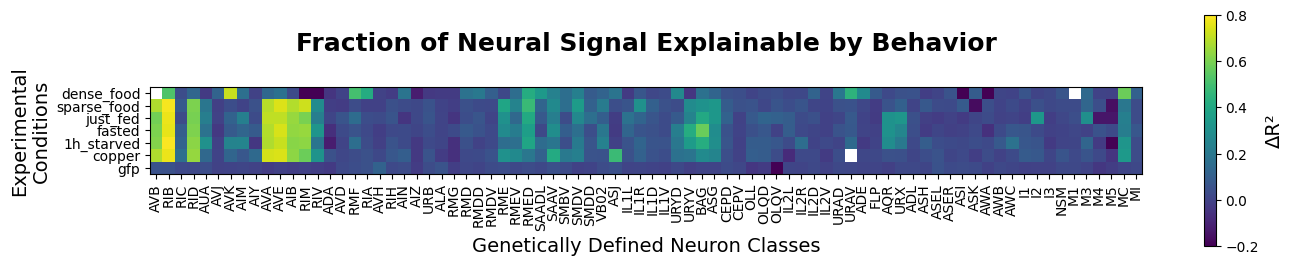

In [38]:
# Compute explanable signals per neuron class per condition
groups = ['dense_food', 'sparse_food', 'just_fed', 'fasted', '1h_starved','copper', 'gfp']
n_neuron_classes = len(fig4_neuron_classes)
n_groups = len(groups)
beh_exp_signal = np.zeros((n_neuron_classes, n_groups))
vel_exp_signal = np.zeros((n_neuron_classes, n_groups))
th_exp_signal  = np.zeros((n_neuron_classes, n_groups))
pump_exp_signal= np.zeros((n_neuron_classes, n_groups))

for (i, nc) in enumerate(fig4_neuron_classes):
    for (j, group) in enumerate(groups):
        full = var_exp[nc][group]['full']
        beh_exp_signal[i][j] = full - var_exp[nc][group]['zero_beh']
        vel_exp_signal[i][j] = full - var_exp[nc][group]['zero_vel']
        th_exp_signal[i][j]  = full - var_exp[nc][group]['zero_th']
        pump_exp_signal[i][j]= full - var_exp[nc][group]['zero_pump']

# Filter out columns (neuron classes) that are entirely NaN
valid_columns = ~np.all(np.isnan(beh_exp_signal), axis=1)
beh_exp_signal_filtered = beh_exp_signal[valid_columns, :]
x_labels_filtered = [fig4_neuron_classes[i] for i in range(len(fig4_neuron_classes)) if valid_columns[i]]

print(f"Keeping {len(x_labels_filtered)} out of {len(fig4_neuron_classes)} neuron classes")
print(f"Filtered out: {[fig4_neuron_classes[i] for i in range(len(fig4_neuron_classes)) if not valid_columns[i]]}")

# Visualize behaviorally explanable signals
plt.figure(figsize=(16,3))
im = plt.imshow(np.transpose(beh_exp_signal_filtered), cmap='viridis')

# Get current axes and set labels
y_labels = groups
ax = plt.gca()
ax.set_xticklabels(x_labels_filtered, rotation=90)
ax.set_yticklabels(y_labels)
ax.set_xticks(range(len(x_labels_filtered)))
ax.set_yticks(range(len(y_labels)))
ax.set_xlabel('Genetically Defined Neuron Classes', fontsize=14)
ax.set_ylabel('Experimental\nConditions', fontsize=14)
ax.set_title('Fraction of Neural Signal Explainable by Behavior\n', fontsize=18, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('ΔR²', fontsize=14)
im.set_clim(-0.2, 0.8)

/tmp/ipykernel_1015333/256029717.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels_filtered_vel, rotation=90)
/tmp/ipykernel_1015333/256029717.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_labels)


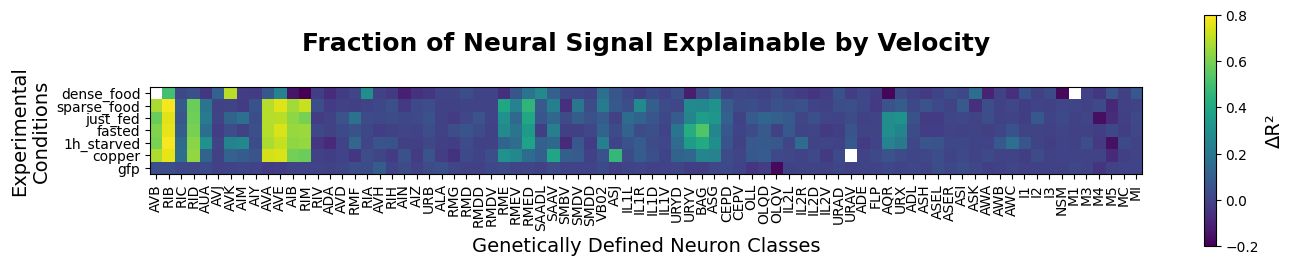

In [39]:
# Filter out columns (neuron classes) that are entirely NaN for velocity signal
valid_columns_vel = ~np.all(np.isnan(vel_exp_signal), axis=1)
vel_exp_signal_filtered = vel_exp_signal[valid_columns_vel, :]
x_labels_filtered_vel = [fig4_neuron_classes[i] for i in range(len(fig4_neuron_classes)) if valid_columns_vel[i]]

# Visualize velocity explanable signals
plt.figure(figsize=(16,3))
im = plt.imshow(np.transpose(vel_exp_signal_filtered), cmap='viridis')
# Get current axes and set labels
y_labels = groups
ax = plt.gca()
ax.set_xticklabels(x_labels_filtered_vel, rotation=90)
ax.set_yticklabels(y_labels)
ax.set_xticks(range(len(x_labels_filtered_vel)))
ax.set_yticks(range(len(y_labels)))
ax.set_xlabel('Genetically Defined Neuron Classes', fontsize=14)
ax.set_ylabel('Experimental\nConditions', fontsize=14)
ax.set_title('Fraction of Neural Signal Explainable by Velocity\n', fontsize=18, fontweight='bold')
# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('ΔR²', fontsize=14)
im.set_clim(-0.2, 0.8)

/tmp/ipykernel_1015333/1472452239.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels_filtered_th, rotation=90)
/tmp/ipykernel_1015333/1472452239.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_labels)


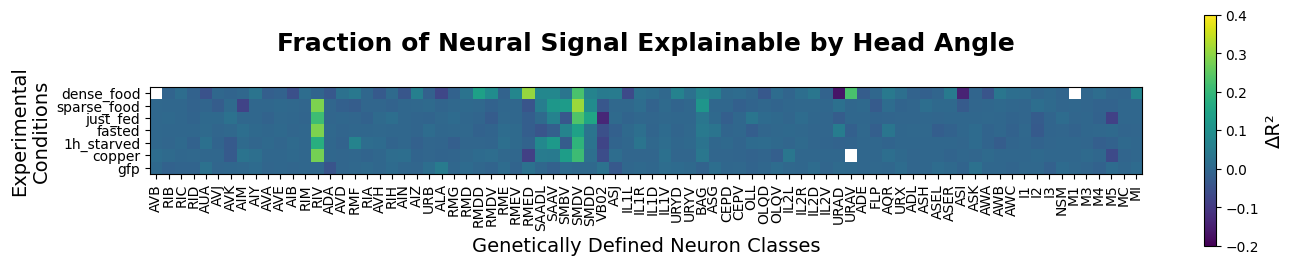

In [43]:
# Filter out columns (neuron classes) that are entirely NaN for head angle signal
valid_columns_th = ~np.all(np.isnan(th_exp_signal), axis=1)
th_exp_signal_filtered = th_exp_signal[valid_columns_th, :]
x_labels_filtered_th = [fig4_neuron_classes[i] for i in range(len(fig4_neuron_classes)) if valid_columns_th[i]]

# Visualize head angle explanable signals
plt.figure(figsize=(16,3))
im = plt.imshow(np.transpose(th_exp_signal_filtered), cmap='viridis')
# Get current axes and set labels
y_labels = groups
ax = plt.gca()
ax.set_xticklabels(x_labels_filtered_th, rotation=90)
ax.set_yticklabels(y_labels)
ax.set_xticks(range(len(x_labels_filtered_th)))
ax.set_yticks(range(len(y_labels)))
ax.set_xlabel('Genetically Defined Neuron Classes', fontsize=14)
ax.set_ylabel('Experimental\nConditions', fontsize=14)
ax.set_title('Fraction of Neural Signal Explainable by Head Angle\n', fontsize=18, fontweight='bold')
# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('ΔR²', fontsize=14)
im.set_clim(-0.2, 0.4)

/tmp/ipykernel_1015333/3374133960.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels_filtered_pump, rotation=90)
/tmp/ipykernel_1015333/3374133960.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_labels)


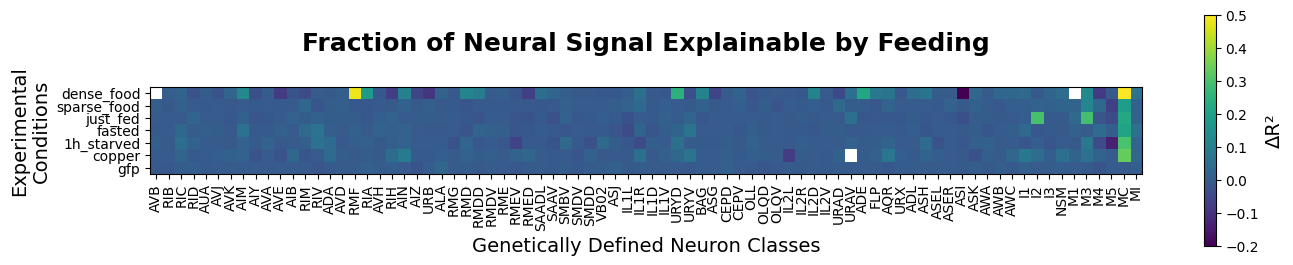

In [46]:
# Filter out columns (neuron classes) that are entirely NaN for feeding signal
valid_columns_pump = ~np.all(np.isnan(pump_exp_signal), axis=1)
pump_exp_signal_filtered = pump_exp_signal[valid_columns_pump, :]
x_labels_filtered_pump = [fig4_neuron_classes[i] for i in range(len(fig4_neuron_classes)) if valid_columns_pump[i]]

# Visualize feeding explanable signals
plt.figure(figsize=(16,3))
im = plt.imshow(np.transpose(pump_exp_signal_filtered), cmap='viridis')
# Get current axes and set labels
y_labels = groups
ax = plt.gca()
ax.set_xticklabels(x_labels_filtered_pump, rotation=90)
ax.set_yticklabels(y_labels)
ax.set_xticks(range(len(x_labels_filtered_pump)))
ax.set_yticks(range(len(y_labels)))
ax.set_xlabel('Genetically Defined Neuron Classes', fontsize=14)
ax.set_ylabel('Experimental\nConditions', fontsize=14)
ax.set_title('Fraction of Neural Signal Explainable by Feeding\n', fontsize=18, fontweight='bold')
# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('ΔR²', fontsize=14)
im.set_clim(-0.2, 0.5)